In [141]:
library(ropls)
library(ggplot2)
library(ggsci)
library(Cairo)
library(tidyverse)
library(extrafont)
loadfonts()

In [142]:
dataMatrix = read.csv('./metabolomics_data.csv',row.names = 1)

In [143]:
dataMatrix = dataMatrix %>% rownames_to_column(.,'Metabolites')

In [144]:
head(dataMatrix,2)

,Metabolites,KO.CLP1,KO.CLP2,KO.CLP3,KO.CLP4,KO.CLP5,KO.CLP6,KO.CLP7,KO.CLP8,KO.NC1,⋯,WT.CLP7,WT.CLP8,WT.NC1,WT.NC2,WT.NC3,WT.NC4,WT.NC5,WT.NC6,WT.NC7,WT.NC8
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"LysoPC(20:4(5Z,8Z,11Z,14Z))",86674.91,218881.9,280332.4,178108.1,119883.5,32693.82,345224.2,119606,153810.9,⋯,20661.54,104916,5804.184,133204.6,243141,277966.9,146089.6,230441.2,140556.2,298852.5
2,LysoPC(18:0),2009726.48,3334212.1,2450525.1,2989967.5,1876162.6,348891.23,2963804.6,2351682,2083188.4,⋯,263312.66,1680189,207871.058,1864903.1,2001310,3029537.8,1408620.2,2274919.8,1574928.0,2431254.0


In [145]:
id = read.csv('/data/workdirV6/cnumber.csv')

In [146]:
data = merge(id,dataMatrix,by = 'Metabolites')

In [147]:
data = data[,-1]

In [148]:
dfuexp <- data[!duplicated(data$kegg),]

In [149]:
rownames(dfuexp) = dfuexp[,1]

In [150]:
dfuexp = dfuexp[,-1]

In [151]:
dataMatrix = dfuexp

In [152]:
 dataMatrix = dataMatrix %>% dplyr::select(contains('WT'))

In [153]:
dataMatrix= t(dataMatrix)

In [154]:
sampleMetadata = read.table('./sample.txt',sep = '\t',header =T,row.names = 1)

In [155]:
sampleMetadata$gender = rep(c('WT-CLP','WT-NC'),each = 8)

In [156]:
variableMetadata = read.csv('./variable.csv',header =T,row.names = 1,check.names = F)

PCA
16 samples x 915 variables
standard scaling of predictors
      R2X(cum) pre ort
Total    0.547   3   0


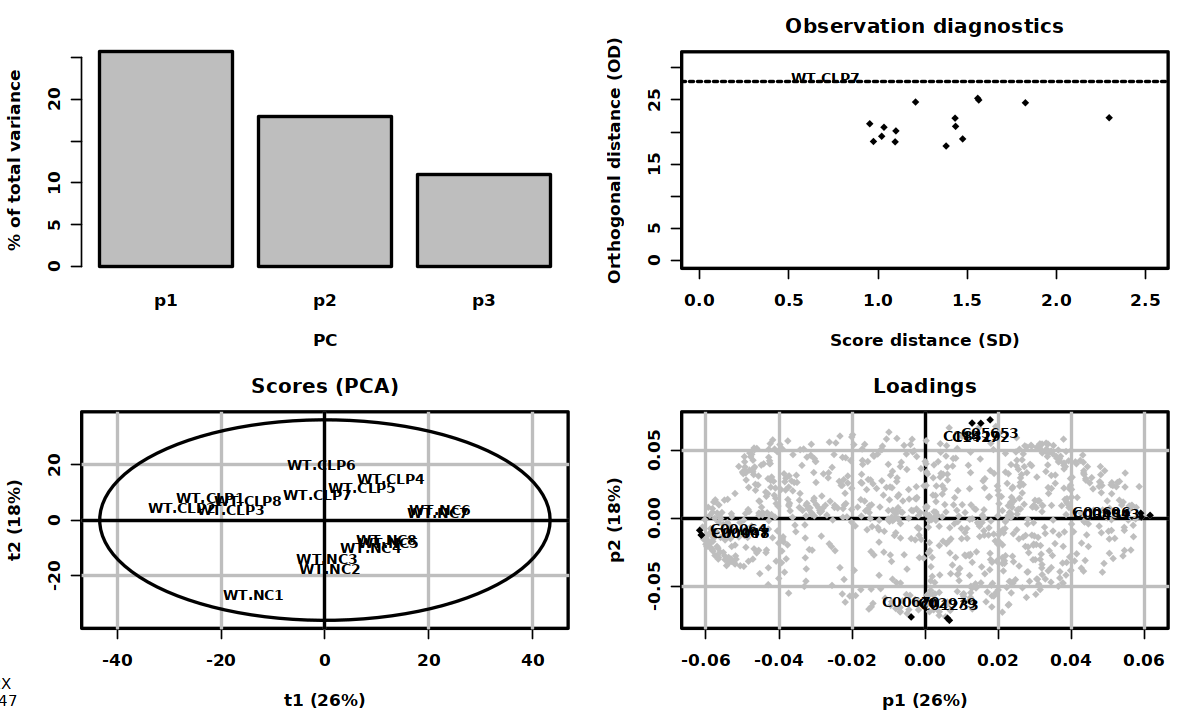

In [157]:
pca = opls(dataMatrix)
genderFc = sampleMetadata[, "group"]

PCA
16 samples x 915 variables
standard scaling of predictors
      R2X(cum) pre ort
Total    0.547   3   0


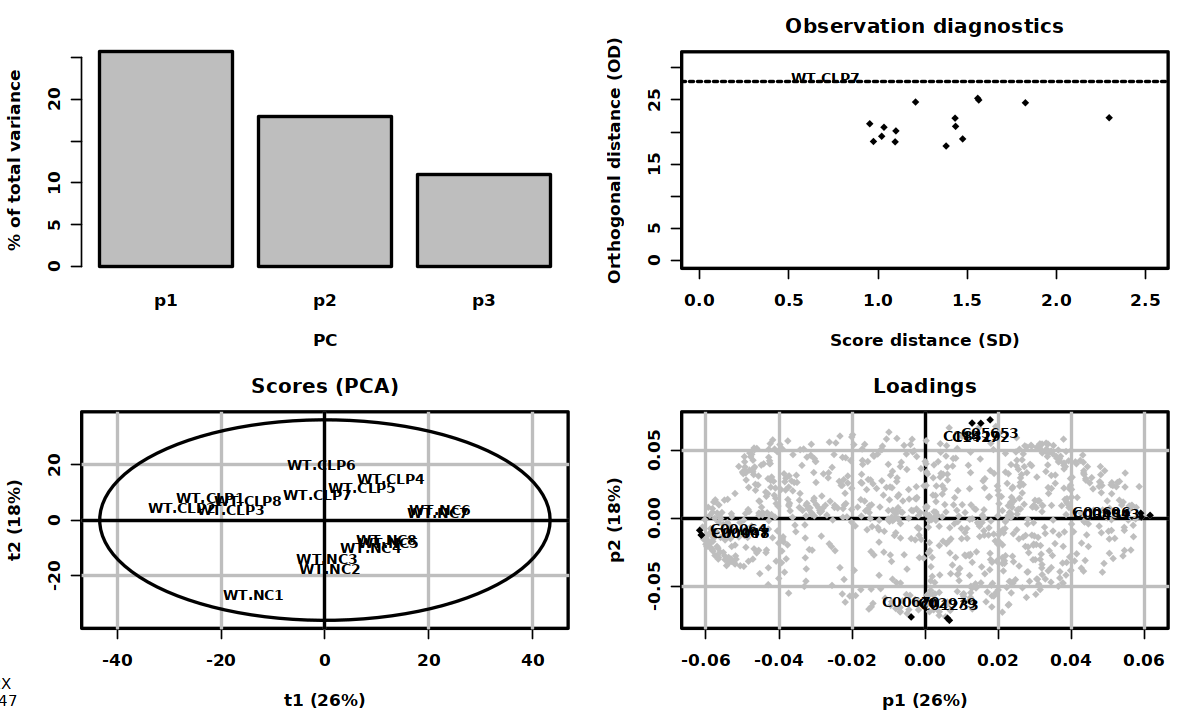

In [158]:
pca = opls(dataMatrix)
groupFc = factor(sampleMetadata[,'group'],levels = c('KO-CLP','WT-CLP'))

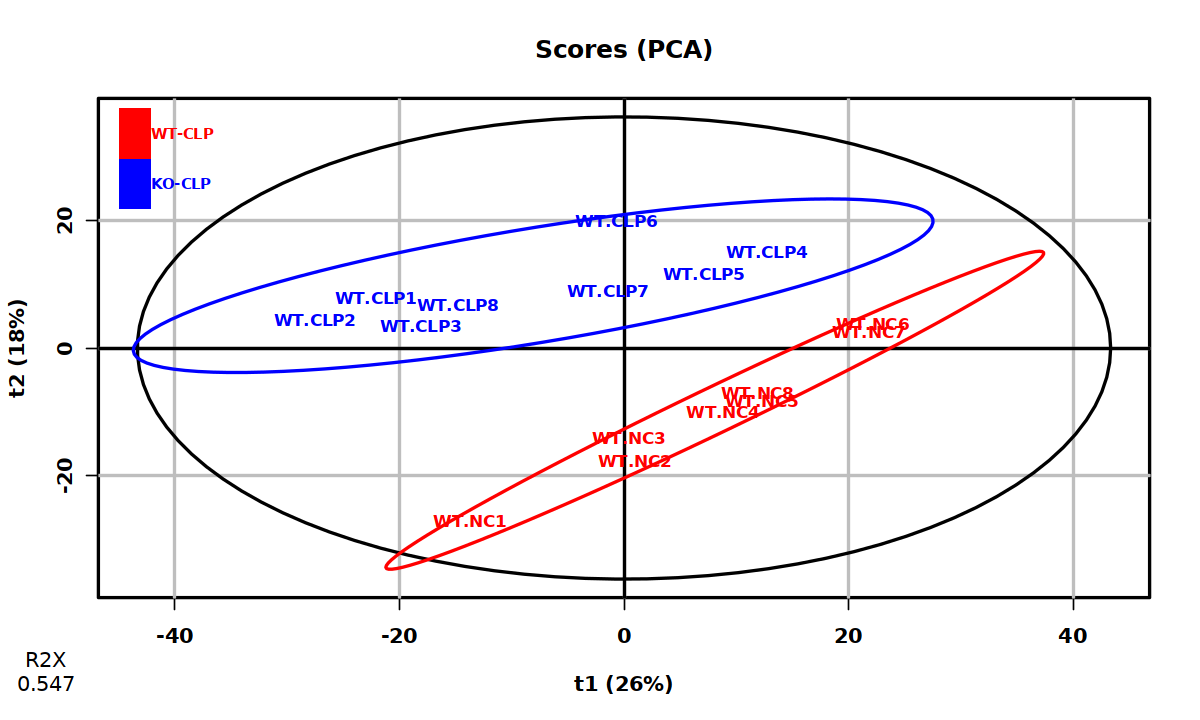

In [159]:
plot(pca, typeVc = "x-score",
     parAsColFcVn = groupFc, parEllipsesL = TRUE)

PLS-DA
16 samples x 915 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum)  RMSEE pre ort pR2Y  pQ2
Total    0.421     0.98     0.9 0.0781   2   0 0.05 0.05


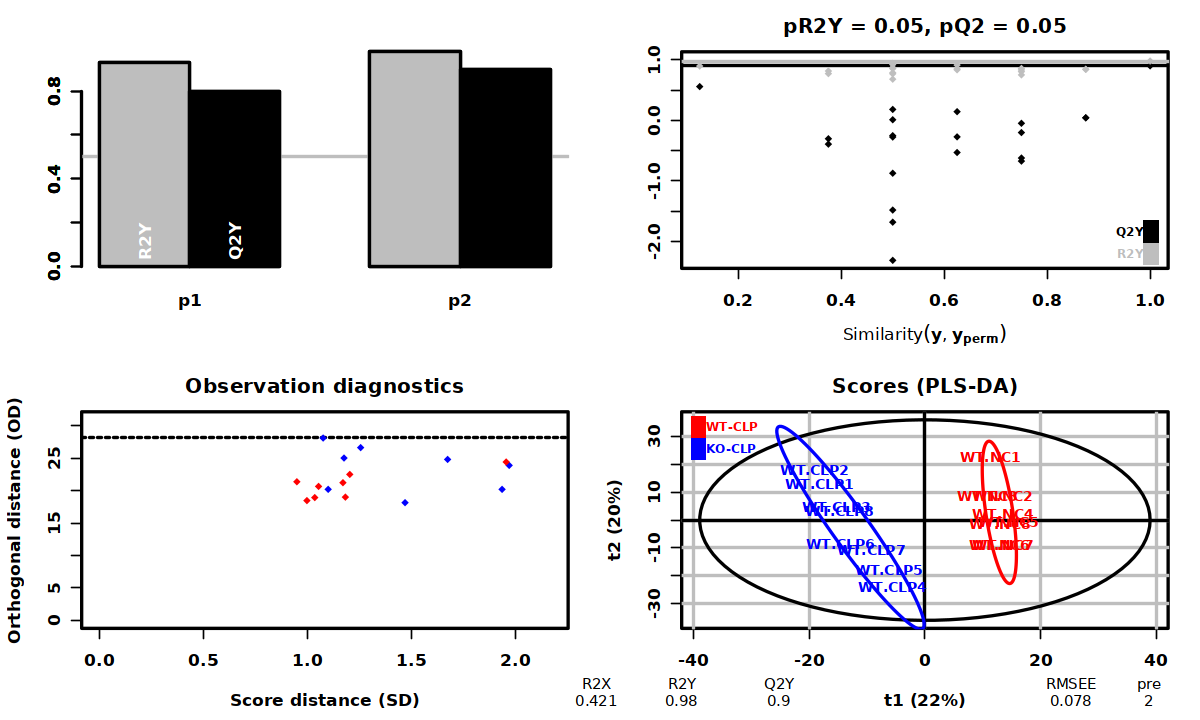

In [160]:
sacurine.plsda <- opls(dataMatrix, groupFc, predI = 2)

In [161]:
sample.score = sacurine.plsda@scoreMN %>% 
  as.data.frame() %>%
  mutate(group = groupFc)

In [162]:
p1 = ggplot(sample.score, aes(p1, p2, color = group)) +
  geom_hline(yintercept = 0, linetype = 'dashed', size = 0.5) +
  geom_vline(xintercept = 0, linetype = 'dashed', size = 0.5) +
  geom_point() +
  geom_point(aes(-10,-10), color = 'white') +
  labs(x = 'P1(10.0%)',y = 'P2(9%)') +
  stat_ellipse(level = 0.95, linetype = 'solid', 
               size = 1, show.legend = FALSE) +
  #scale_color_manual(values = c('#008000','#FFA74F')) +
  theme_bw() +
  theme(legend.position = c(0.9,0.8),
    legend.text = element_text(color = 'black',size = 12, family = 'Arial', face = 'plain'),
    panel.background = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(color = 'black',size = 15, family = 'Arial', face = 'plain'),
    axis.title = element_text(color = 'black',size = 15, family = 'Arial', face = 'plain'),
    axis.ticks = element_line(color = 'black'))

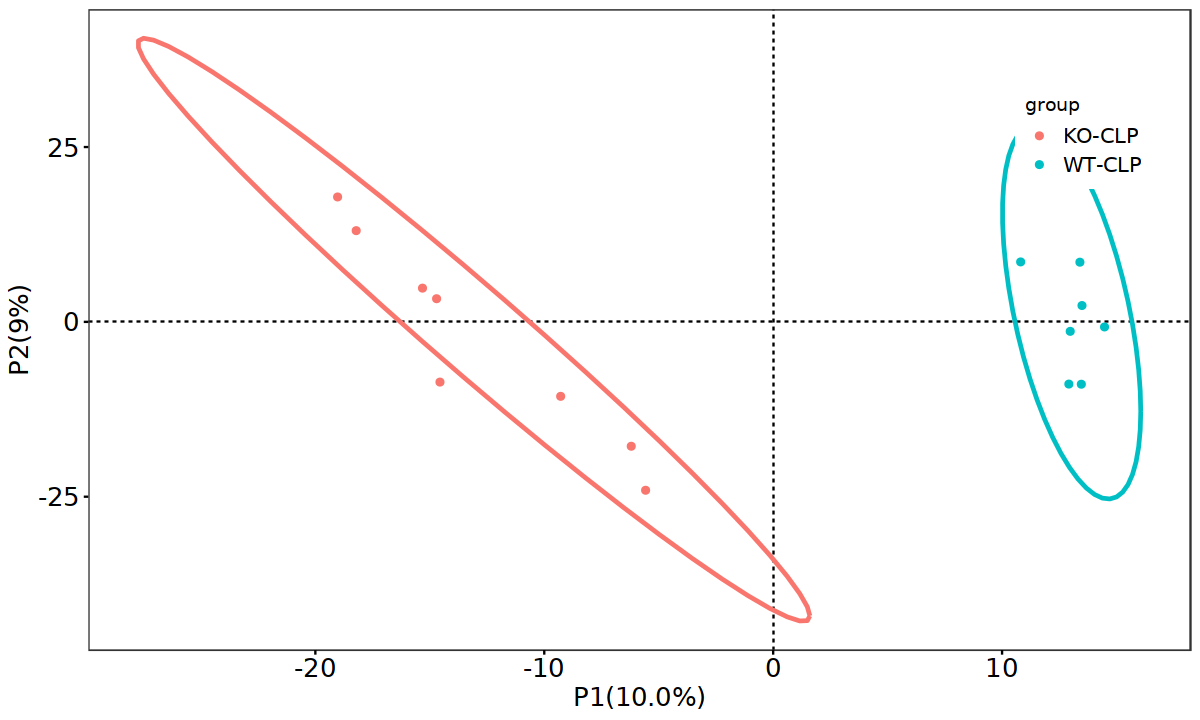

In [163]:
p1

In [164]:
vip.score = as.data.frame(sacurine.plsda@vipVn)
colnames(vip.score) = 'vip'
vip.score$metabolites = rownames(vip.score)
vip.score = vip.score[order(-vip.score$vip),]
vip.score$metabolites = factor(vip.score$metabolites,
                               levels = vip.score$metabolites)

In [165]:

loading.score = sacurine.plsda@loadingMN %>% as.data.frame()
loading.score$metabolites = rownames(loading.score)
 
all.score = merge(vip.score, loading.score, by = 'metabolites')
 
all.score$cat = paste('A',1:nrow(all.score), sep = '')

In [166]:

p2 = ggplot(all.score[all.score$vip >= 1,], aes(cat, vip)) +
  geom_segment(aes(x = cat, xend = cat,
                   y = 0, yend = vip)) +
  geom_point(shape = 21, size = 5, color = '#008000' ,fill = '#008000') +
  geom_point(aes(1,2.5), color = 'white') +
  geom_hline(yintercept = 1, linetype = 'dashed') +
  scale_y_continuous(expand = c(0,0)) +
  labs(x = '', y = 'VIP value') +
  theme_bw() +
  theme(legend.position = 'none',
        legend.text = element_text(color = 'black',size = 12, family = 'Arial', face = 'plain'),
        panel.background = element_blank(),
        panel.grid = element_blank(),
        axis.text = element_text(color = 'black',size = 15, family = 'Arial', face = 'plain'),
        axis.text.x = element_text(angle = 90),
        axis.title = element_text(color = 'black',size = 15, family = 'Arial', face = 'plain'),
        axis.ticks = element_line(color = 'black'),
        axis.ticks.x = element_blank())


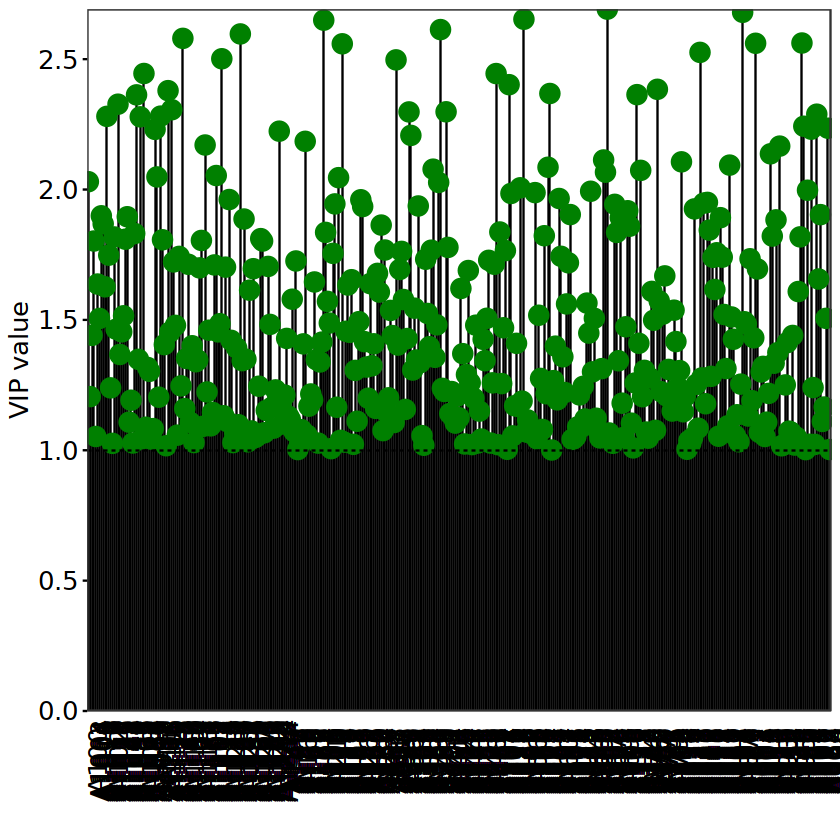

In [44]:
p2

In [167]:
Sys.setlocale('LC_ALL','C')

[1] "LC_CTYPE=C;LC_NUMERIC=C;LC_TIME=C;LC_COLLATE=C;LC_MONETARY=C;LC_MESSAGES=en_US.UTF-8;LC_PAPER=en_US.UTF-8;LC_NAME=C;LC_ADDRESS=C;LC_TELEPHONE=C;LC_MEASUREMENT=en_US.UTF-8;LC_IDENTIFICATION=C"

In [168]:
aa = cbind(as.data.frame(all.score$metabolites),all.score$vip)

In [169]:
colnames(aa) = c('metabolites','vip')

In [170]:
aa = aa %>% filter(vip >1)

In [103]:
write.csv(aa,file = 'vip.csv',row.names =F)

### OPLS-DA分析

Warning message:
"OPLS: number of predictive components ('predI' argument) set to 1"


OPLS-DA
16 samples x 915 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum)  RMSEE pre ort pR2Y  pQ2
Total    0.503    0.998   0.917 0.0284   1   2 0.05 0.05


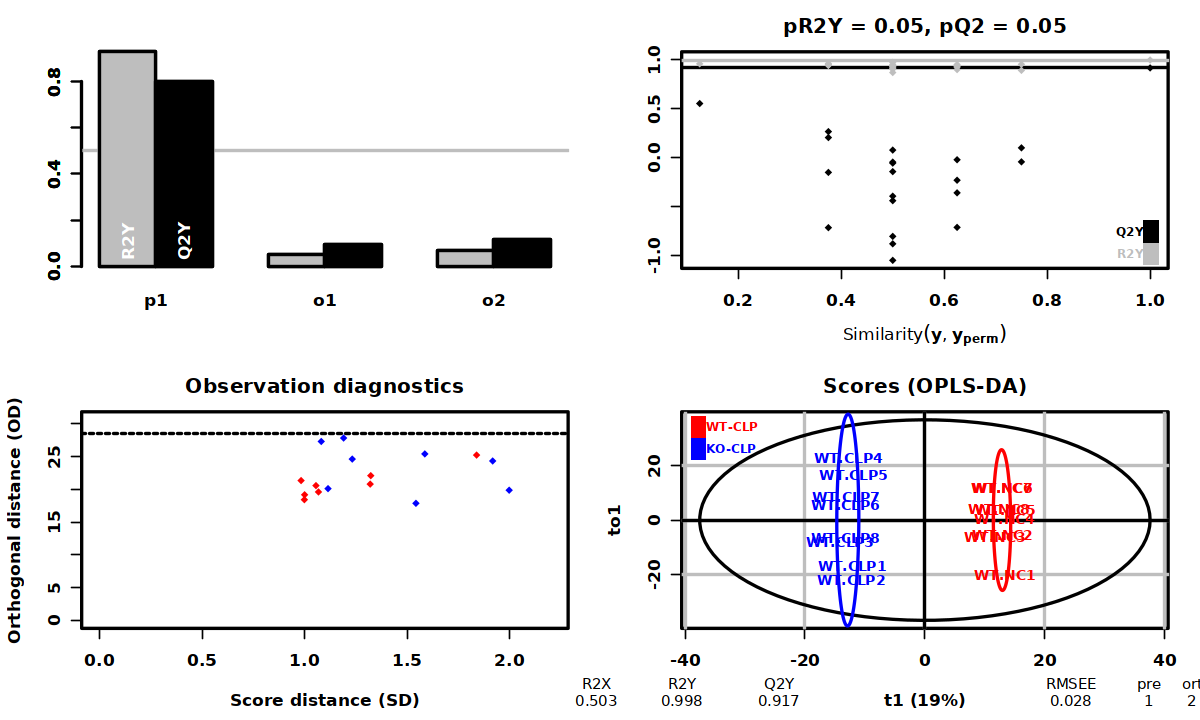

In [171]:
oplsda = opls(dataMatrix, genderFc, predI = 3,orthoI = NA)

In [172]:
sample.score = oplsda@scoreMN %>% 
  as.data.frame() %>%
   mutate(group = groupFc)

In [173]:
vip.score = as.data.frame(oplsda@vipVn)
colnames(vip.score) = 'vip'
vip.score$metabolites = rownames(vip.score)
vip.score = vip.score[order(-vip.score$vip),]
vip.score$metabolites = factor(vip.score$metabolites,
                               levels = vip.score$metabolites)
 
loading.score = oplsda@loadingMN %>% as.data.frame()
loading.score$metabolites = rownames(loading.score)
 
all.score = merge(vip.score, loading.score, by = 'metabolites')
 
all.score$cat = paste('A',1:nrow(all.score), sep = '')

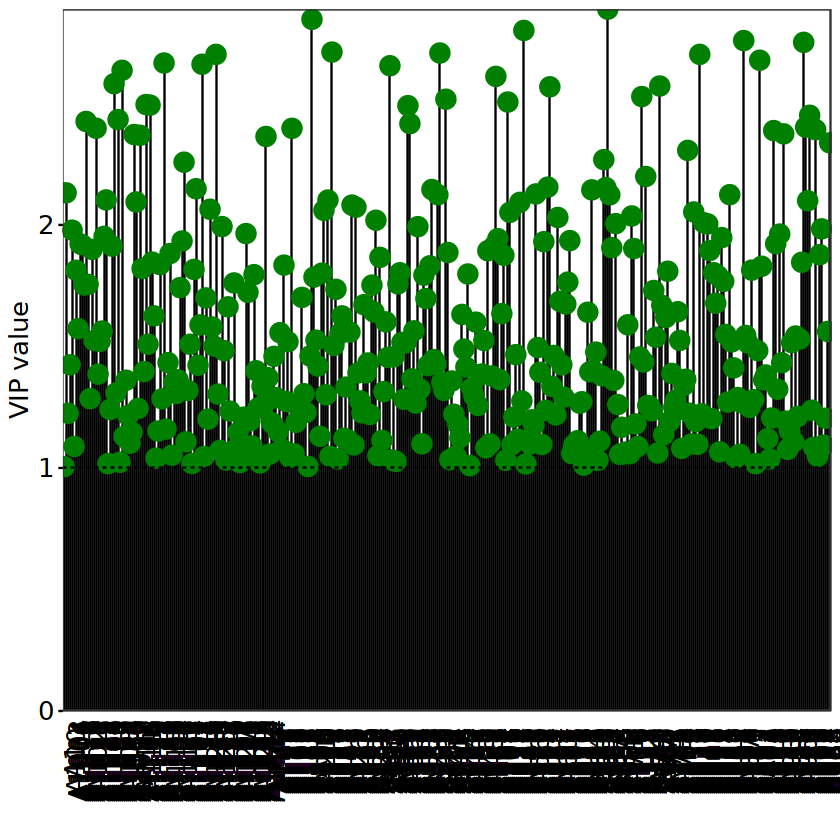

In [67]:
p4 = ggplot(all.score[all.score$vip >= 1,], aes(cat, vip)) +
  geom_segment(aes(x = cat, xend = cat,
                   y = 0, yend = vip)) +
  geom_point(shape = 21, size = 5, color = '#008000' ,fill = '#008000') +
  geom_point(aes(1,2.5), color = 'white') +
  geom_hline(yintercept = 1, linetype = 'dashed') +
  scale_y_continuous(expand = c(0,0)) +
  labs(x = '', y = 'VIP value') +
  theme_bw() +
  theme(legend.position = 'none',
        legend.text = element_text(color = 'black',size = 12, family = 'Arial', face = 'plain'),
        panel.background = element_blank(),
        panel.grid = element_blank(),
        axis.text = element_text(color = 'black',size = 15, family = 'Arial', face = 'plain'),
        axis.text.x = element_text(angle = 90),
        axis.title = element_text(color = 'black',size = 15, family = 'Arial', face = 'plain'),
        axis.ticks = element_line(color = 'black'),
        axis.ticks.x = element_blank())
p4

In [174]:

all.score = all.score %>% filter(vip > 1.5)

In [108]:
aa = read.csv('./vip.csv')

In [175]:
length(intersect(all.score$metabolites,aa$metabolites))

[1] 142

In [97]:
write.csv(all.score,file = 'oplsda-vip1.5.csv',row.names =F)

In [176]:
df = dataMatrix %>% as.data.frame()
df$gender = groupFc
df = df[order(df$gender),]

In [178]:
df = df[,-916]

In [179]:
M.mean = apply(df[1:8,],2,FUN = mean)
F.mean = apply(df[9:16,],2,FUN = mean)

In [180]:
FC = M.mean / F.mean
log2FC = log(FC,2)

In [181]:
pvalue = apply(df, 2, function(x)
  {t.test(x[1:8],x[9:16])$p.value})

In [182]:
p.adj = p.adjust(pvalue, method = 'BH')
p.adj.log = -log10(p.adj)
 
colcano.df = data.frame(log2FC,p.adj,pvalue, p.adj.log)
colcano.df$cat = ifelse(colcano.df$log2FC >= 1 & colcano.df$pvalue < 0.05,'Up',
                        ifelse(colcano.df$log2FC <= -1 & colcano.df$pvalue < 0.05,'Down','NS'))


In [183]:
table(colcano.df$cat )


Down   NS   Up 
  68  768   79 

In [184]:
pathway = read.csv('/data/workdirV6/KEGG_COMPOUND_PATHWAY_mmu.csv')

In [185]:
pathway = pathway[,c(2,6)]

In [186]:
colnames(pathway) = c('term','gene')

In [187]:
data_all_sort <- colcano.df %>%
 arrange(desc(log2FC))

In [188]:
geneList = data_all_sort$log2FC 
names(geneList) <- rownames(data_all_sort)
head(geneList)

C01301   C05993   C14869   C05958   C05476   C05498 
32.76445 32.06300 31.83907 31.77002 31.27500 30.60753

In [189]:
data_all_sort

,log2FC,p.adj,pvalue,p.adj.log,cat
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
C01301,32.76445,0.139941430,3.670595e-02,0.8540537,Up
C05993,32.06300,0.294093715,1.189890e-01,0.5315143,NS
C14869,31.83907,0.301181011,1.227765e-01,0.5211724,NS
C05958,31.77002,0.059733077,8.698504e-03,1.2237851,Up
C05476,31.27500,0.010014936,3.757799e-04,1.9993518,Up
C05498,30.60753,0.047649288,5.444523e-03,1.3219436,Up
C05487,30.59514,0.002261111,1.774935e-05,2.6456781,Up
C00500,30.56665,0.203126771,6.349099e-02,0.6922328,NS
C05949,30.42852,0.108612660,2.397788e-02,0.9641196,Up


In [190]:
library(tidyverse)
library(data.table)
library(org.Hs.eg.db)
library(clusterProfiler)
library(biomaRt)
library(enrichplot)

In [191]:
gsea <- GSEA(geneList,
            TERM2GENE = pathway,
            pvalueCutoff = 1,minGSSize = 10,maxGSSize = 500,eps =0) 

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



In [192]:
gsea@result

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Steroid hormone biosynthesis - Mus musculus (house mouse),Steroid hormone biosynthesis - Mus musculus (house mouse),Steroid hormone biosynthesis - Mus musculus (house mouse),45,0.9096875,1.4690232,5.071138e-06,0.0002484858,0.0002188596,39,"tags=40%, list=4%, signal=40%",C05476/C05498/C05487/C05299/C05478/C05489/C05477/C05471/C05139/C00762/C05302/C01780/C05474/C05469/C00735/C05481/C05490/C02140
Arachidonic acid metabolism - Mus musculus (house mouse),Arachidonic acid metabolism - Mus musculus (house mouse),Arachidonic acid metabolism - Mus musculus (house mouse),53,0.8692933,1.4012258,3.933117e-04,0.0096361367,0.0084872525,43,"tags=21%, list=5%, signal=21%",C05958/C05949/C14771/C02165/C00427/C05966/C14717/C14776/C14768/C04707/C14732
Retinol metabolism - Mus musculus (house mouse),Retinol metabolism - Mus musculus (house mouse),Retinol metabolism - Mus musculus (house mouse),11,0.9292065,1.4393126,7.063649e-03,0.1153729285,0.1016174022,21,"tags=18%, list=2%, signal=18%",C16678/C11061
Inflammatory mediator regulation of TRP channels - Mus musculus (house mouse),Inflammatory mediator regulation of TRP channels - Mus musculus (house mouse),Inflammatory mediator regulation of TRP channels - Mus musculus (house mouse),15,0.9006779,1.3958519,1.460275e-02,0.1788836417,0.1575559465,40,"tags=20%, list=4%, signal=19%",C02165/C05966/C14768
"Valine, leucine and isoleucine biosynthesis - Mus musculus (house mouse)","Valine, leucine and isoleucine biosynthesis - Mus musculus (house mouse)","Valine, leucine and isoleucine biosynthesis - Mus musculus (house mouse)",12,-0.6687591,-1.5105787,2.041002e-02,0.2000181561,0.1761706638,72,"tags=42%, list=8%, signal=39%",C02504/C00109/C04236/C00233/C06007
Glycerophospholipid metabolism - Mus musculus (house mouse),Glycerophospholipid metabolism - Mus musculus (house mouse),Glycerophospholipid metabolism - Mus musculus (house mouse),15,-0.6348616,-1.5813266,3.991957e-02,0.2846659895,0.2507262206,84,"tags=40%, list=9%, signal=37%",C00350/C00157/C04230/C00670/C01233/C00093
Linoleic acid metabolism - Mus musculus (house mouse),Linoleic acid metabolism - Mus musculus (house mouse),Linoleic acid metabolism - Mus musculus (house mouse),18,-0.5558729,-1.4868257,4.647608e-02,0.2846659895,0.2507262206,173,"tags=61%, list=19%, signal=51%",C06426/C14835/C01595/C14825/C00219/C14833/C00157/C03242/C07338/C14829/C14831
Serotonergic synapse - Mus musculus (house mouse),Serotonergic synapse - Mus musculus (house mouse),Serotonergic synapse - Mus musculus (house mouse),31,0.8378392,1.3371766,4.180464e-02,0.2846659895,0.2507262206,40,"tags=16%, list=4%, signal=16%",C14771/C02165/C00427/C05966/C14768
Pyruvate metabolism - Mus musculus (house mouse),Pyruvate metabolism - Mus musculus (house mouse),Pyruvate metabolism - Mus musculus (house mouse),11,0.8848695,1.3706360,6.544503e-02,0.3425294286,0.3016907964,2,"tags=9%, list=0%, signal=9%",C05993


In [139]:
options(repr.plot.height = 6,repr.plot.width = 10)

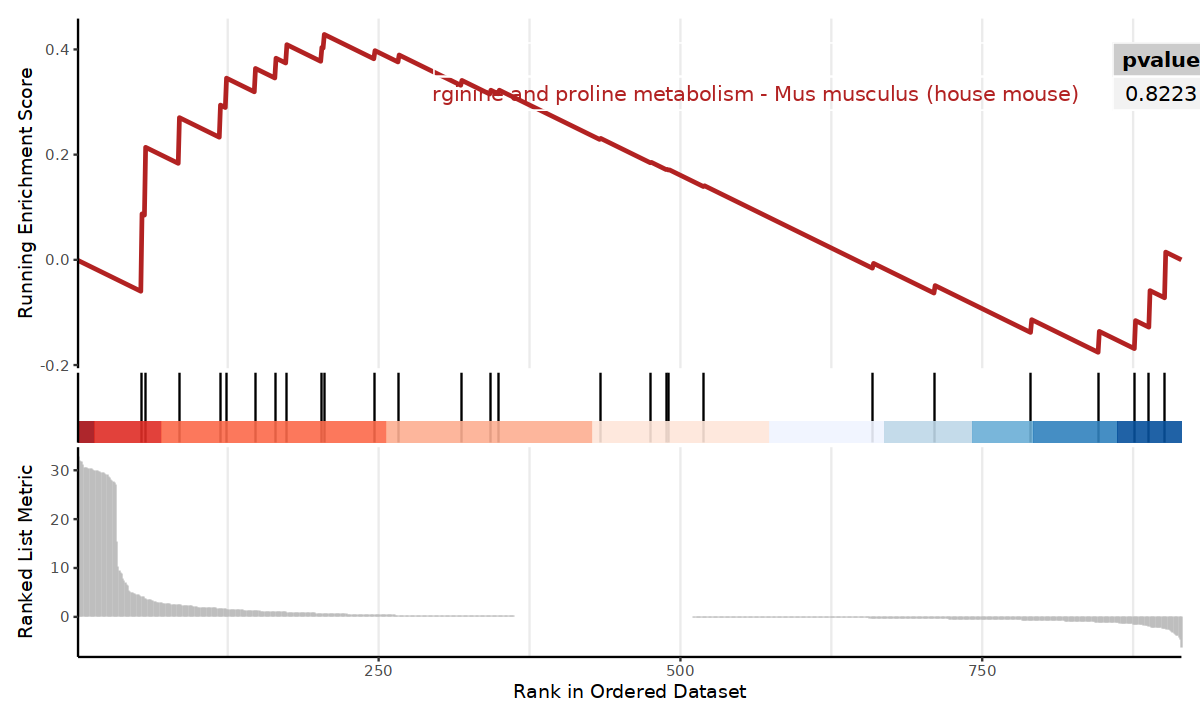

In [193]:
gseaplot2(gsea, "Arginine and proline metabolism - Mus musculus (house mouse)", color = "firebrick",  pvalue_table = TRUE,rel_heights=c(1, .2, .6))

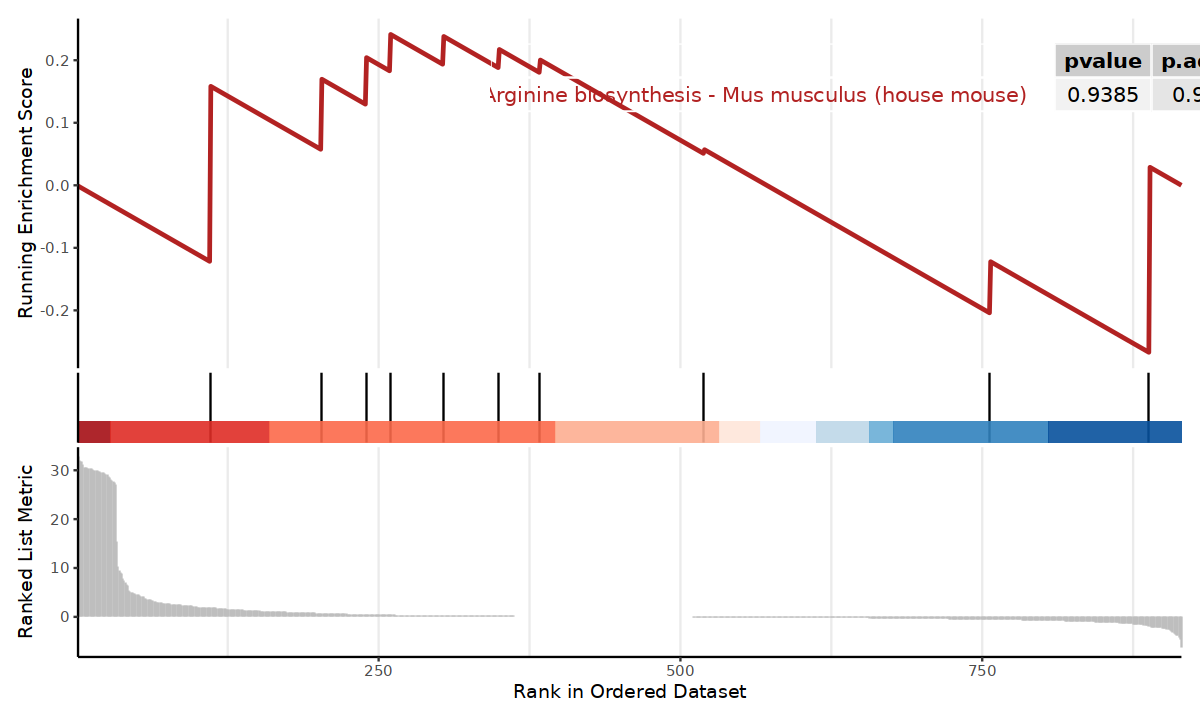

In [194]:
gseaplot2(gsea, "Arginine biosynthesis - Mus musculus (house mouse)", color = "firebrick",  pvalue_table = TRUE,rel_heights=c(1, .2, .6))